In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# Load the datasets
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')




# Get the number of rows and columns for each DataFrame
rows_columns_X_train = X_train.shape
rows_columns_y_train = y_train.shape

# Output the number of rows and columns
print(f"X_train rows, columns: {rows_columns_X_train}")
print(f"y_train rows, columns: {rows_columns_y_train}")

X_train rows, columns: (10229, 26)
y_train rows, columns: (10229, 3)


In [134]:
# Merge the DataFrames on 'Identifiant'
df = pd.merge(X_train, y_train, on='Identifiant')
df.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'], inplace=True)
df['EXPO'] = df['EXPO'].apply(lambda x: float(str(x).replace(',', '.')))
df['ft_24_categ'] = df['ft_24_categ'].str.strip()
df['ft_24_categ'] = df['ft_24_categ'].replace('.', np.nan)
df.drop('ft_24_categ', axis=1, inplace=True)
df.to_csv('merged_data.csv', index=False)

In [135]:
target = 'target'
labels = ['Claimed','Not Claimed']
features = [i for i in df.columns.values if i not in ["Identifiant", target]]


In [136]:
original_df = df.copy(deep=True)
display(df.head())
print('\n\033[1mInference:\033[0m The Dataset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))


,Identifiant,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_9_categ,ft_10_categ,...,ft_16_categ,ft_17_categ,ft_18_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,ft_23_categ,Insee,target
0,18702,2014,1.000000,0,V,N,1,O,1,O,...,IDENTIQUE,V,base,2,1351.0,4,2012.0,0.0,65440,0
1,3877,2014,1.000000,0,V,V,V,V,V,V,...,V,N,base,2,1972.0,2,1980.0,0.0,14341,1
2,4942,2013,1.000000,1,V,V,V,V,V,V,...,V,N,base,2,1630.0,4,NaN,0.0,75109,0
3,13428,2013,0.246575,0,N,V,V,V,V,V,...,V,N,base,2,532.0,3,NaN,0.0,92004,0
4,17137,2015,1.000000,0,V,N,2,O,1,O,...,IDENTIQUE,V,base,2,1050.0,2,1972.0,0.0,59340,0



Inference: The Dataset consists of 25 features & 10229 samples.


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10229 entries, 0 to 10228
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Identifiant  10229 non-null  int64  
 1   ft_2_categ   10229 non-null  int64  
 2   EXPO         10229 non-null  float64
 3   ft_4_categ   10229 non-null  int64  
 4   ft_5_categ   10229 non-null  object 
 5   ft_6_categ   10229 non-null  object 
 6   ft_7_categ   10229 non-null  object 
 7   ft_8_categ   10229 non-null  object 
 8   ft_9_categ   10229 non-null  object 
 9   ft_10_categ  10229 non-null  object 
 10  ft_11_categ  10229 non-null  object 
 11  ft_12_categ  10229 non-null  object 
 12  ft_13_categ  10229 non-null  object 
 13  ft_14_categ  10229 non-null  object 
 14  ft_15_categ  10229 non-null  object 
 15  ft_16_categ  10229 non-null  object 
 16  ft_17_categ  10229 non-null  object 
 17  ft_18_categ  10229 non-null  object 
 18  ft_19_categ  10229 non-null  int64  
 19  supe

In [138]:
#Checking the stats of all the columns

display(df.describe())

,Identifiant,ft_2_categ,EXPO,ft_4_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,target
count,10229.000000,10229.000000,10229.000000,10229.000000,10229.000000,10110.000000,10229.000000,8993.000000,10229.000000
mean,9969.220745,2013.646789,0.913672,0.281064,1.938508,1818.152918,2.238049,1965.061715,0.227002
std,5619.328018,1.380660,0.233806,0.449540,0.240242,2272.111284,0.961589,33.548619,0.418914
min,0.000000,2012.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1545.000000,0.000000
25%,5198.000000,2012.000000,1.000000,0.000000,2.000000,500.000000,2.000000,1960.000000,0.000000
50%,9820.000000,2013.000000,1.000000,0.000000,2.000000,1002.000000,2.000000,1970.000000,0.000000
75%,14922.000000,2015.000000,1.000000,1.000000,2.000000,2190.000000,3.000000,1980.000000,0.000000
max,19995.000000,2016.000000,1.000000,1.000000,2.000000,30745.000000,4.000000,2016.000000,1.000000


In [139]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

target             2
ft_19_categ        2
ft_4_categ         2
ft_16_categ        2
ft_15_categ        2
ft_17_categ        3
ft_14_categ        3
ft_12_categ        3
ft_11_categ        3
ft_13_categ        3
ft_8_categ         3
ft_6_categ         3
ft_5_categ         3
ft_10_categ        3
ft_9_categ         4
ft_7_categ         4
ft_21_categ        4
ft_18_categ        5
ft_2_categ         5
ft_23_categ        7
ft_22_categ      139
EXPO             467
Insee           1525
superficief     2463
Identifiant    10229
dtype: int64

In [140]:
nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=7:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 4 numerical & 19 categorical features.


In [144]:
# Print the names of the numerical columns
print("Numerical columns:", nf)

Numerical columns: ['ft_22_categ', 'EXPO', 'Insee', 'superficief']


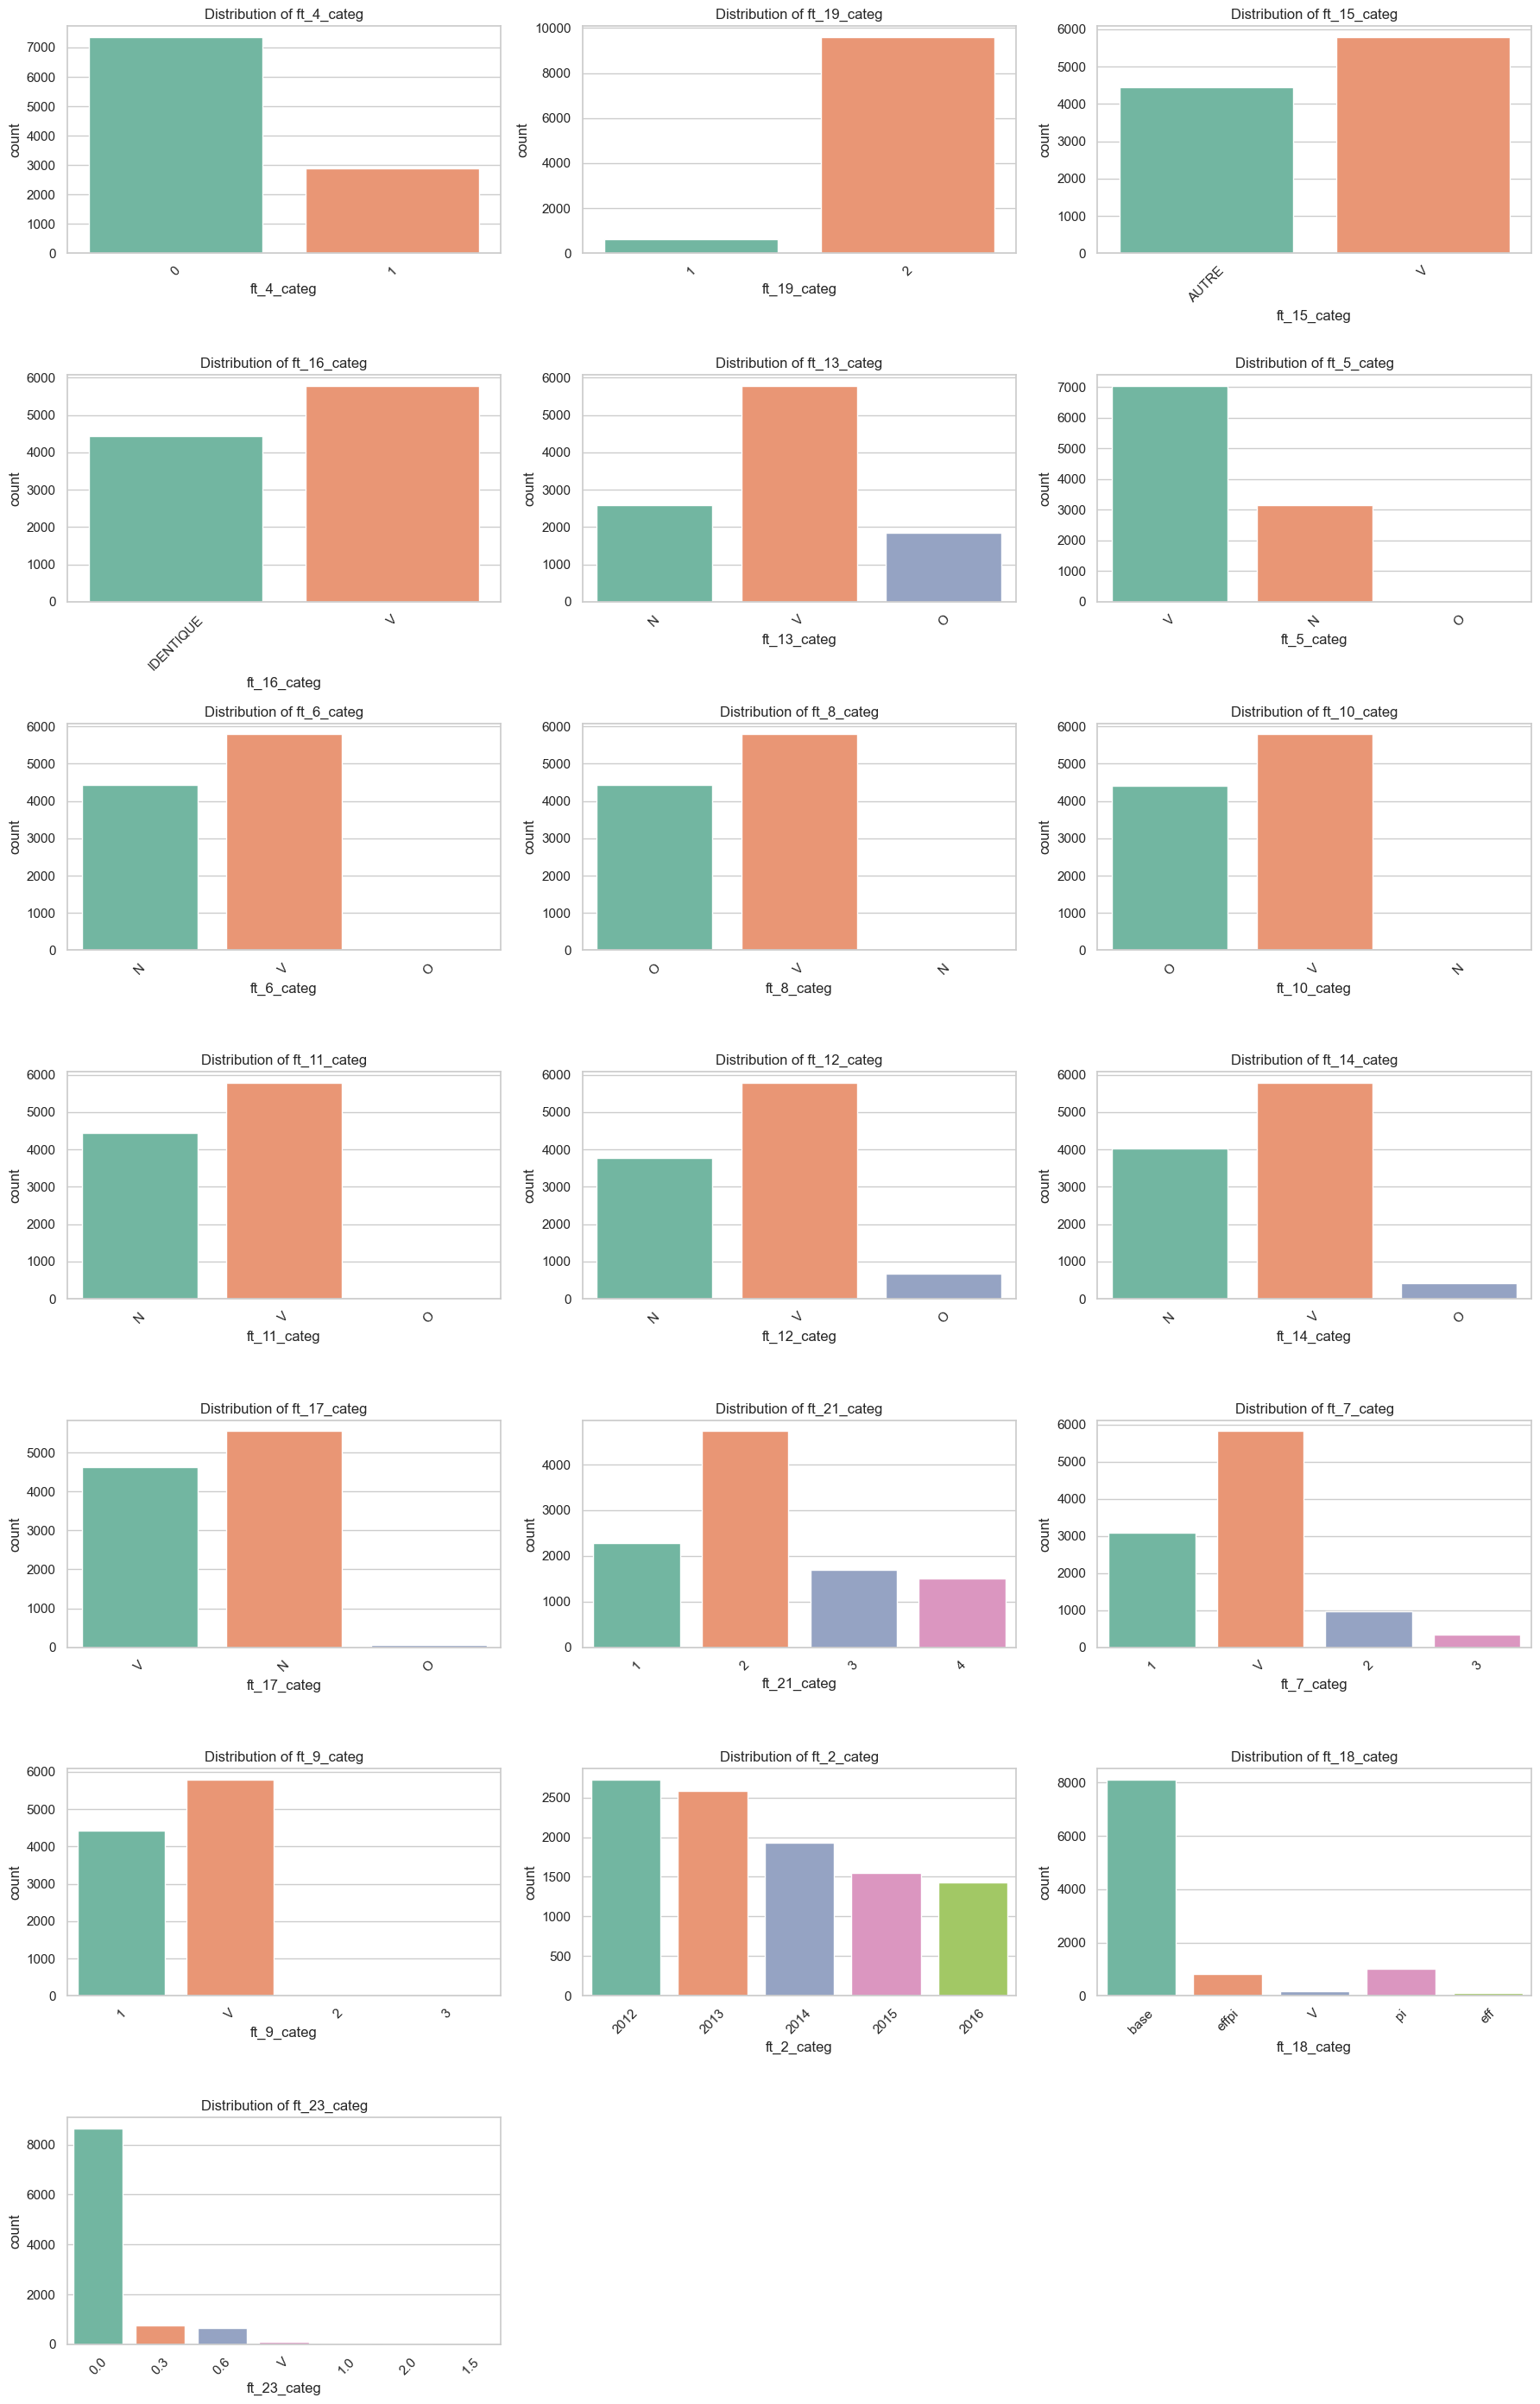

In [141]:

# Set the number of plots per row
plots_per_row = 3  # Adjust based on your preference and screen size

# Calculate the required number of rows to accommodate all categorical features
num_rows = len(cf) // plots_per_row + (len(cf) % plots_per_row > 0)

# Set the overall figure size
plt.figure(figsize=(18, num_rows * 4))  # Width, Height - adjust as needed

# Loop through the list of categorical features to create subplots
for i, feature in enumerate(cf):
    plt.subplot(num_rows, plots_per_row, i + 1)  # Rows, Columns, Plot number
    sns.countplot(x=feature, data=df, palette='Set2')
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)  # Rotate the labels to avoid overlap

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()

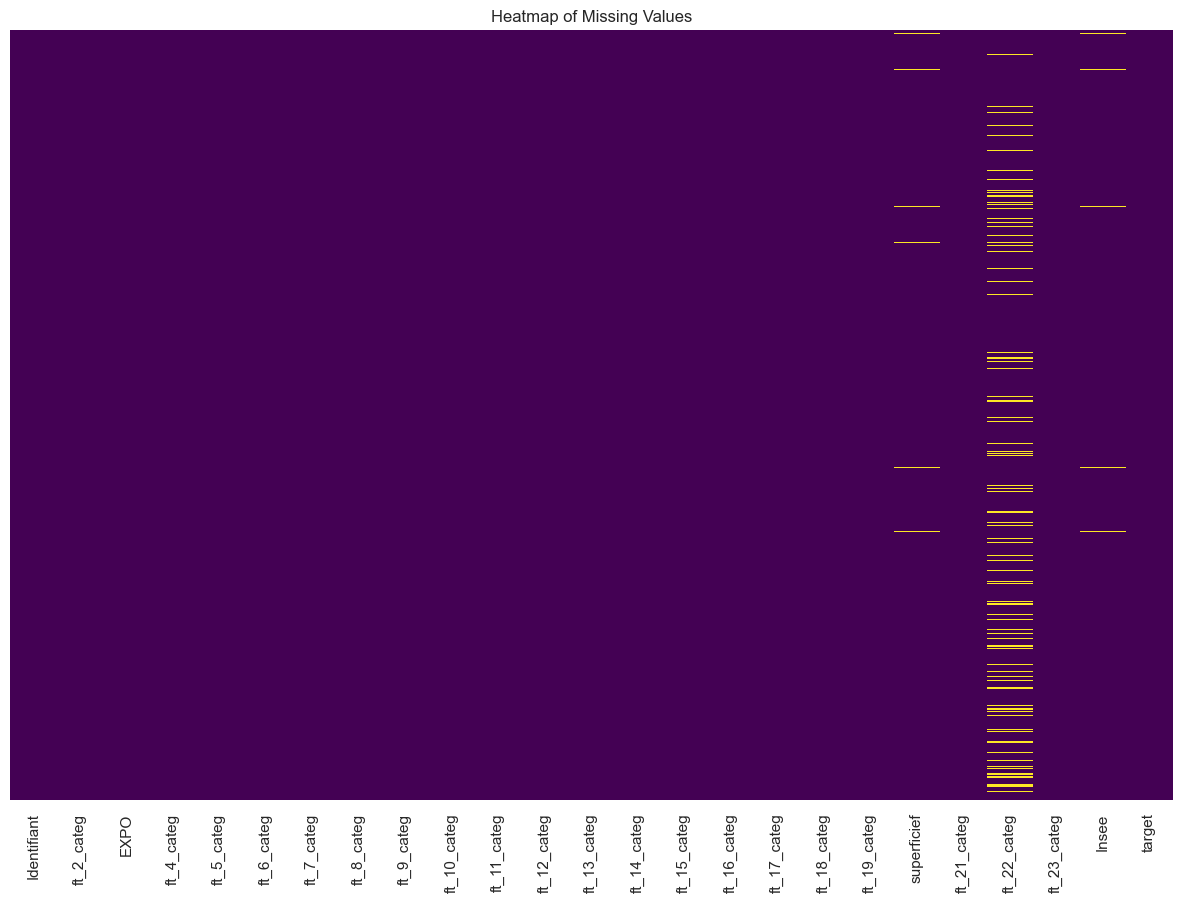

In [142]:


# Calculate a boolean DataFrame where True represents missing values
missing = df.isnull()

# Create a heatmap to visualize the missing values
plt.figure(figsize=(15, 10))  # Adjust the figure size as necessary
sns.heatmap(missing, cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Values')
plt.show()


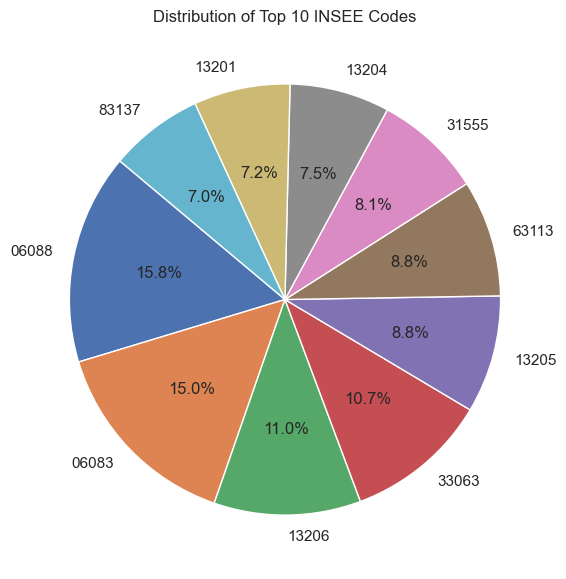

In [151]:
insee_counts = df['Insee'].value_counts()
top_10_insee_counts = insee_counts.head(10)
plt.figure(figsize=(10, 7)) 
plt.pie(top_10_insee_counts, labels=top_10_insee_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Top 10 INSEE Codes')
plt.show()



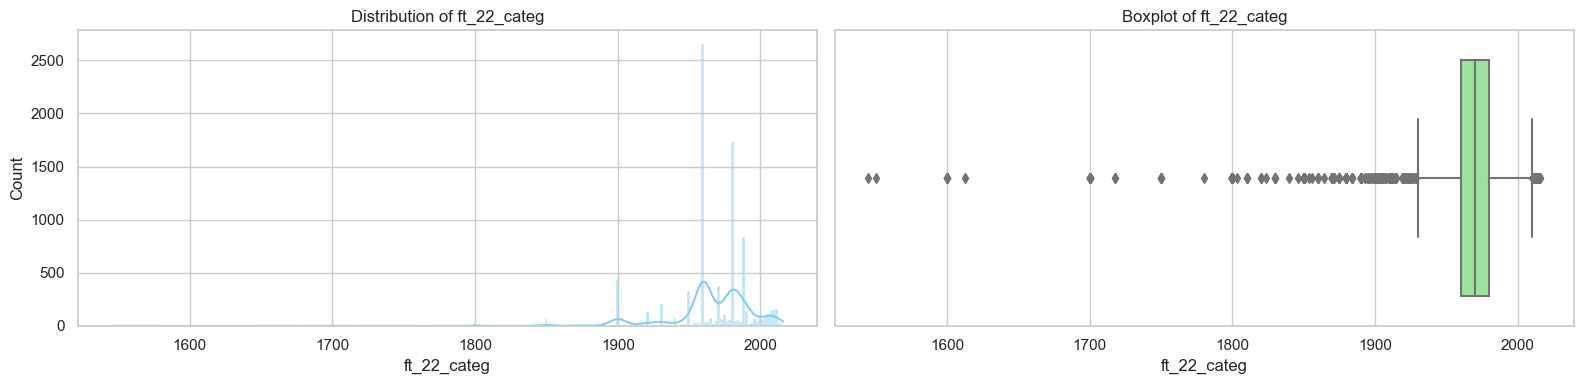

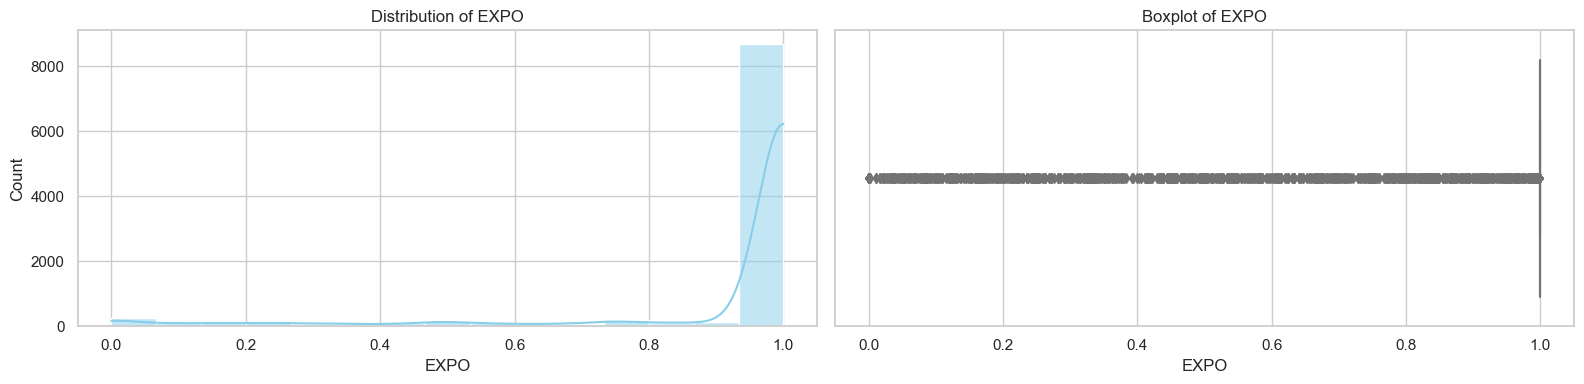

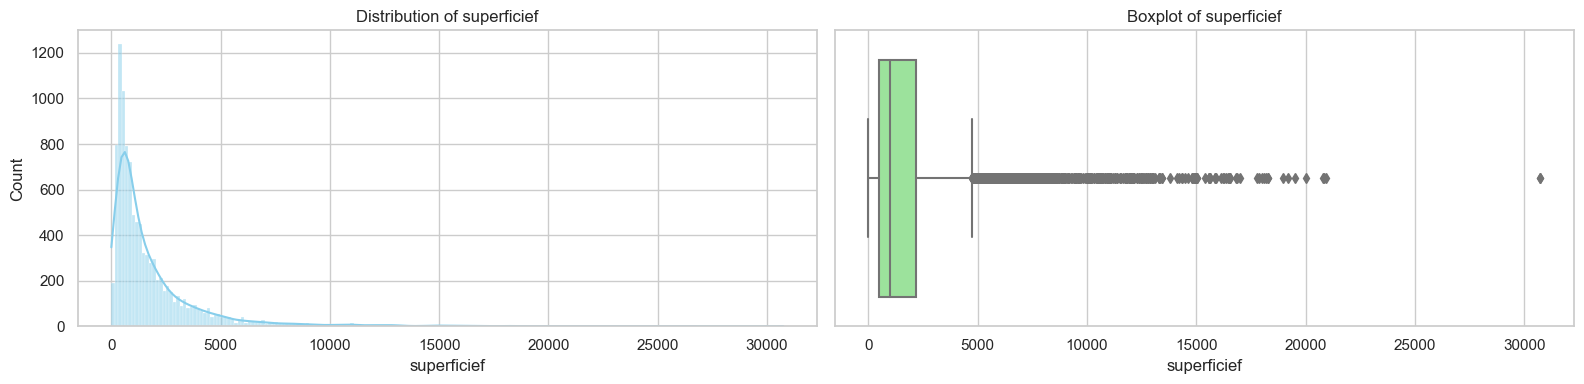

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt
for feature in nf:
    if feature == 'Insee':
        continue
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    sns.histplot(df[feature].dropna(), ax=axes[0], color='skyblue', kde=True)
    axes[0].set_title(f'Distribution of {feature}')
    sns.boxplot(x=df[feature], ax=axes[1], color='lightgreen')
    axes[1].set_title(f'Boxplot of {feature}')
    plt.tight_layout()
    plt.show()


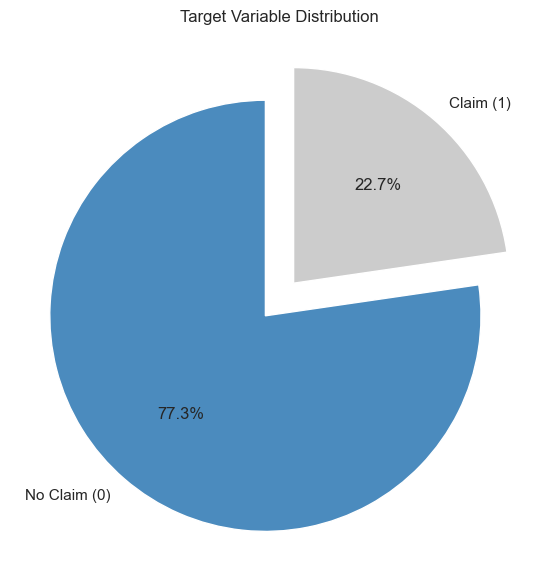

In [154]:

sns.set()
target_counts = df['target'].value_counts()
labels = ['No Claim (0)', 'Claim (1)']
explode = (0.1, 0.1)
plt.figure(figsize=(7, 7))
plt.pie(target_counts, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode,
        colors = ['#4B8BBE', '#CCCCCC'] 
)
plt.title('Target Variable Distribution')
plt.show()

In [1]:
x=10
print(x)

10
